In [40]:
from pymongo import MongoClient
import certifi
import os
from dotenv import load_dotenv
from utils.translation import translate_text
from utils.courses import find_courses_by_name, retrieve_lessons_text, get_google_translations_from_txt, encode_course_by_lesson 
import pandas as pd
from functools import partial, reduce
from random import randint

In [2]:
#Load env variables
load_dotenv()
MONGO_URI = os.environ["MONGO_DB_URI"]
PATH = os.environ["DIR_PATH"]

In [3]:
#Load the gcf data from the MongoDB db
ca = certifi.where()
cluster = MongoClient(host=MONGO_URI, tlsCAFile=ca)
db = cluster["gcfglobal"]
collection_lessons = db["lesson"]
collection_tutorials = db['tutorial']

# Build a dictionary with all the courses lessons

- Additionally, we generate colors for each course

In [22]:
paths = [
    ('como-usar-o-twitter', 'como-usar-twitter'),
    ('excel-2016',), 
    ('microsoft-excel-2010',), 
    ('microsoft-word-2010',), 
    ('powerpoint-2019',), 
    ('word-2016',),
    ('algebra',), 
    ('credito',), 
    ('curso-de-fotografia-digital',), 
    ('curso-de-photoshop',), 
    ('informatica-basica',),
    ('whatsapp-business',), 
    ('virus-e-antivirus','virus-informaticos-y-antivirus'),
    ('criacao-de-sites','creacion-de-sitios-web'),
    ('seguranca-na-internet', 'seguridad-en-internet'),
    ('criar-um-correio-eletronico', 'crear-un-correo-electronico'),
    ('como-criar-um-blog', 'crear-un-blog-en-internet'),
    ('apresentacoes-basicas', 'presentaciones-basicas'),
    ('como-usar-o-telegram', 'curso-de-telegram'),
    ('tudo-sobre-o-windows-10', 'como-usar-windows-10'),
    ('como-usar-o-sistema-android', 'como-usar-android'),
    ('criar-uma-conta-no-facebook', 'crear-cuenta-en-facebook'),
    ('aplicativos', 'aplicaciones'),
    ('google-sala-de-aula-para-alunos', 'google-classroom-para-estudiantes'),
    ('somar-e-subtrair', 'sumar-y-restar'),
    ('como-fazer-multiplicacao', 'multiplicar'),
    ('divisao', 'dividir'),
    ('multiplos-e-divisores', 'divisores-y-multiplos'),
    ('numeros-fracionarios', 'fraccionarios'),
    ('os-numeros-decimais', 'los-decimales'),
    ('os-conjuntos-matematicos', 'los-conjuntos'),
    ('usando-a-matematica', 'aplicaciones-de-la-matematica'),
    ('conceitos-basicos-da-matematica', 'temas-basicos'),
    ('empreendedorismo', 'emprendimiento'),
    ('criatividade','creatividad'),
    ('os-caminhos-da-graduacao', 'acceso-a-la-educacion-superior'),
    ('credito',),
    ('conceitos-basicos-de-design-grafico', 'conceptos-basicos-de-diseno-grafico'),
]

In [23]:
f = partial(find_courses_by_name, collection_tutorials)
g = (lambda x: retrieve_lessons_text(collection_lessons, f(x)))

In [ ]:
complete_lessons = reduce(lambda x,y: x | y, map(g,paths), dict()) 

In [25]:
courses = list(complete_lessons.keys())

In [28]:
def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Get encodings (lesson level) with Google Translate Text Included

In [36]:
h = partial(get_google_translations_from_txt, '/Users/elefantickets/git/analisis_traducciones/data/translate')
google_translations = list(zip(courses,(map(lambda x: h(x,complete_lessons), courses))))

In [41]:
complete_lessons_encodings = reduce(lambda x, y: x | y, map(lambda x: encode_course_by_lesson(complete_lessons, x[0],'multi-qa-distilbert-cos-v1',x[1]),google_translations), dict())

# PCA for each of the encodings

In [62]:
from utils.courses import keys_to_tuple
import numpy as np

In [65]:
total_encodings = np.concatenate(list(map(lambda x: complete_lessons_encodings[x[0]][x[1]], keys_to_tuple(complete_lessons_encodings))))

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(total_encodings)

PCA(n_components=2)

In [71]:
pca_vectors = list(map(lambda x: ((x[0],x[1]),pca.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))

In [77]:
import pickle as pkl

with open('pca_vectors.pickle', 'wb') as handle:
    pkl.dump(pca_vectors, handle, protocol=pkl.HIGHEST_PROTOCOL)

# Gráfica por Curso (nivel de lesson)

In [99]:
from colour import Color

In [146]:
import random
def generate_colors(courses: list,colors=[]):
    if len(colors) == len(courses):
        return colors
    else:
        r = round(random.uniform(0,1),2)
        g = round(random.uniform(0,1),2)
        b = round(random.uniform(0,1),2)
        return generate_colors(courses, [*colors, Color(rgb=(r,g,b)).get_hex_l()])

In [168]:
colors_for_course = list(zip(courses,generate_colors(courses)))

In [169]:
colors_dict = dict(colors_for_course)

In [ ]:
import matplotlib.pyplot as plt

for (course_name, language), vectors in pca_vectors:
    if language == 'google':
        continue
    print(course_name)
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])


# Graficar por lenguaje

In [150]:
language_color_dict = {'es': '#FF0000', 'pt': '#0000FF', 'google': '#00FF00'}
#Verde: Google
#Español: Español
#Azul: Portugues

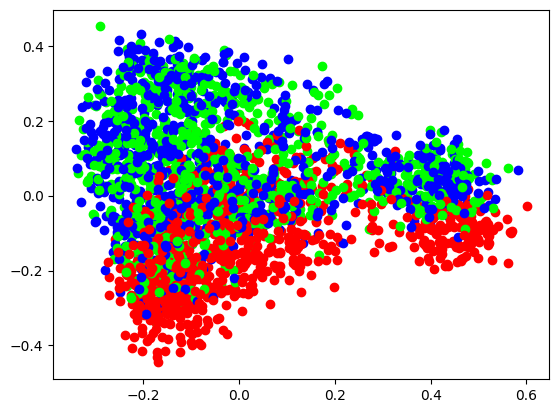

In [151]:
for (course_name, language), vectors in pca_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=language_color_dict[language])